### Import libraries

In [1]:
%%capture
! pip install git+https://github.com/ildoonet/cutmix

In [2]:
%%capture
import os
import random
import warnings
from time import perf_counter, sleep

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from cutmix.cutmix import CutMix
from scipy import stats
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sklearn.metrics import confusion_matrix
from torchvision.models import resnet18

warnings.filterwarnings("ignore")

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
num_workers = 0

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


### Load dataset

In [5]:
def load_dataset(
        batch_size, 
        transform_method,
        number_of_models=1,
    ):
    """
    Used to load data set with desired transformation and batch size
    
    :param batch_size: set batch_size of train and test data
    :type batch_size: int
    :param transform_method: choose method of transformation dataset
    :type transform_method: str
    :param number_of_models: used in ensemble for taking subset of CIFAR10 data
    :type transform_method: int

    :returns: Dataset splited in train and test with desired transformation
    :rtype: torch.utils.data.dataloader.DataLoader
    """

    # Basic transformation which is done for each image
    base = [
            transforms.ToTensor(), 
            transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)),
    ]

    # More complex transformations chosen on the basis of transform_method parameter
    if transform_method in ["base", "cutmix"]:
        transform = transforms.Compose(
            base
        )
    elif transform_method == "random_rotation":
        transform = transforms.Compose(
            base + [transforms.RandomRotation((30,70))]
        )
    elif transform_method == "random_horizontal_flip":
        transform = transforms.Compose(
            base + [transforms.RandomHorizontalFlip(0.2)]
        )
    elif transform_method == "gray_scale":
        transform = transforms.Compose(
            base + [transforms.Grayscale(3)]
        )
    else:
        raise Exception("Transform method not found!")

    # Download and load CIFAR10 dataset
    train_set = torchvision.datasets.CIFAR10(root='./downloaded_data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./downloaded_data', train=False, download=True, transform=transform)

    subset = random.sample(
        range(0, len(train_set)), 
        int(len(train_set) / number_of_models),
    )
    train_set_subset = torch.utils.data.Subset(train_set, subset)

    # If the value of the parameter indicates it, then perform a cutmix transformation
    if transform_method == "cutmix":
        train_set = CutMix(
            train_set, 
            num_class=10, # Number of classes
            beta=1.0, # parameters of distribution Beta(beta, beta) 
            prob=0.2, # probability of image to be cutmixed
            num_mix=10,  # number of changes
        )

        test_set = CutMix(
            test_set, 
            num_class=10, # Number of classes
            beta=1.0, # parameters of distribution Beta(beta, beta) 
            prob=0.2, # probability of image to be cutmixed
            num_mix=10,  # number of changes
        )

    # Divide the dataset into batches and perform the shuffling
    train_loader=torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader=torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

    return train_loader, test_loader

In [6]:
train_loader, test_loader = load_dataset(batch_size=4, transform_method="base")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Show example images

In [7]:
def show_image(image):
    image=image/2 +0.5
    img_numpy=image.numpy()
    plt.imshow(np.transpose(img_numpy, (1,2,0)))
    plt.show()

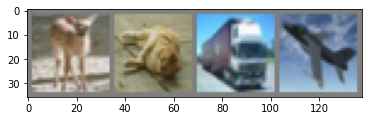

In [8]:
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

In [9]:
labels_str=""
for i in range(4):
    labels_str+=classes[labels[i]]+", "

print(labels_str)

deer, cat, truck, plane, 


### Neural network architectures

In [10]:
class SimpleNetBaseline1(nn.Module):
    """
    Simple convolutional neural network defined in our document
    """
    def __init__(self):
        super(SimpleNetBaseline1, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = torch.nn.Conv2d(3,8,5)
        self.conv2 = torch.nn.Conv2d(8,16,5)
   
        self.pool = torch.nn.MaxPool2d(2,2)
        self.flatten = torch.nn.Flatten()
   
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

class SimpleNetBaseline2(nn.Module):
    """
    A variant of the simple convolutional network described in our document
    """
    def __init__(self):
        super(SimpleNetBaseline2, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.conv1 = torch.nn.Conv2d(3,8,5)
        self.conv2 = torch.nn.Conv2d(8,16,5)
        
        self.pool = torch.nn.MaxPool2d(2,2)
        self.flatten = torch.nn.Flatten()
        
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 100)
        self.fc2 = torch.nn.Linear(100, 30)
        self.fc3 = torch.nn.Linear(30, 10)

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x  

class MoreComplexNet(nn.Module):
    """
    More complex neural network described in our document
    """
    def __init__(self, dropout_p):
        super(MoreComplexNet, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = torch.nn.Conv2d(3,32,3, padding=1)
        self.conv2 = torch.nn.Conv2d(32,32,3, padding=1)
        self.conv3 = torch.nn.Conv2d(32,64,3, padding=1)
        self.conv4 = torch.nn.Conv2d(64,64,3, padding=1)

        self.dropout = torch.nn.Dropout(dropout_p)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.flatten = torch.nn.Flatten()
        
        self.fc1 = torch.nn.Linear(64 * 8 * 8, 64)
        self.fc2 = torch.nn.Linear(64, 10)
        
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.pool(self.relu(self.conv2(self.relu(self.conv1(x)))))
        x = self.dropout(x)
        x = self.pool(self.relu(self.conv4(self.relu(self.conv3(x)))))
        x = self.dropout(x)
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.softmax(self.fc2(x), dim=1)


        return x  

### Train neural networks

In [11]:
def nn_training(
    train_loader,
    test_loader,
    nn_name, 
    nn_type, 
    n_epochs,
    l2,
    learning_rate, 
    momentum,
    dropout_p = 0, 
    is_cutmix=False,
    number_of_models=1,
):
    """
    Train neural network with specific hiperparameters and save it in .pth format.
    
    :param train_loader: set batch_size of train and test data
    :type train_loader: torch.utils.data.dataloader.DataLoader
    :param test_loader: set batch_size of train and test data
    :type test_loader: torch.utils.data.dataloader.DataLoader

    :param nn_name: name of .pth file
    :type nn_name: str
    :param nn_type: type of neural network architecture to be used
    :type nn_type: str
    :param n_epochs: number of epochs
    :type nn_type: int

    :param l2: lambda parameter in ridge regularization
    :type l2: double
    :param learning_rate: learning_rate used in SGD optimizer 
    :type learning_rate: double
    :param momentum: momentum used in SGD optimizer, 
        helps accelerate gradients vectors in the right directions
    :type momentum: double
    :param dropout_p: determinates probability of zeroed the element
    :type dropout_p: double, range: [0, 1]
    
    :param is_cutmix: determines whether cutmix transformation is used, 
        useful for counting metrics
    :type is_cutmix: bool

    """

    # Choose desired neural network architecture
    if nn_type == "SimpleNetBaseline1":
        neural_network = SimpleNetBaseline1()
    elif nn_type == "SimpleNetBaseline2":
        neural_network = SimpleNetBaseline2()
    elif nn_type == "MoreComplexNet":
        neural_network = MoreComplexNet(dropout_p)
    elif nn_type == "ResNet_not_pretrained":
        neural_network = resnet18(pretrained=False)
        neural_network.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
        for name, module in neural_network.named_children():
            if name == 'fc':
                continue
            module = nn.Sequential(module, nn.Dropout(p=dropout_p))
    elif nn_type =="ResNet_pretrained":
        neural_network = resnet18(pretrained=True)
        neural_network.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
        for name, module in neural_network.named_children():
            if name == 'fc':
                continue
            module = nn.Sequential(module, nn.Dropout(p=dropout_p))
    else:
        raise Exception("Invalid neural network type!")
    
    neural_network.to(device)
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Select an optimizer (in our case SGD) 
    # with specific hyperparameters related to training
    optimizer = optim.SGD(
        neural_network.parameters(), 
        lr=learning_rate, 
        momentum=momentum,
        weight_decay=l2
    )
    test_acc_list = []
    # Epochs loop
    for epoch in range(n_epochs):
        train_loss = 0.0
        train_acc = 0.0
        flag = 0
        # Batch loop
        for i, data in enumerate(train_loader, 0):
            # Train neural network
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = neural_network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            outputs = outputs if device=="cpu" else outputs.cpu()
            labels = labels if device=="cpu" else labels.cpu()

            # if cutmix, do not take argmax because of the expanded label
            _, predicted = torch.max(outputs.data, 1) # predict with argmax

            if is_cutmix:
                acc = top_k_accuracy_score(np.array(predicted), np.array(labels), k=2, labels=list(range(0, 10)))
                train_acc+=acc
            else:
                # calculate accuracy
                acc = accuracy_score(labels, predicted)
                train_acc+=acc

            train_loss += loss.item()
            
            # print loss and accuracy on test data every 1500 mini-batches
            if i % 1500 == 1499:    
                # neural_network.eval()
                test_acc = 0.0
                count = 0
                for j, data_test in enumerate (test_loader, 0):
                    input_test, label_test = data_test
                    input_test, label_test = input_test.to(device),label_test.to(device)

                    output_test = neural_network(input_test)

                    output_test = output_test if device=="cpu" else output_test.cpu()
                    label_test = label_test if device=="cpu" else label_test.cpu()
                    
                    _, predicted = torch.max(output_test.data, 1)
                    if is_cutmix:
                        acc_test = top_k_accuracy_score(predicted, label_test, k=2, labels=list(range(0, 10)))
                        test_acc += acc_test 
                    else:
                        acc_test = accuracy_score(label_test, predicted)
                        test_acc += acc_test
                    count +=1
                # printing statistics
                print(f'[{epoch + 1}] batch[{i+1}] loss: {train_loss / 1500:.3f}, train accuracy: {train_acc/1500:.3f}, test accuracy {test_acc/count:.3f} ')
                test_acc_list.append(test_acc/count)
                train_loss = 0.0
                train_acc = 0.0

                # early stopping
                if len(test_acc_list) > 4:
                    if abs(test_acc_list[-1] - test_acc_list[-2]) <= 0.002 and abs(test_acc_list[-2] - test_acc_list[-3]) <= 0.002 and abs(test_acc_list[-3] - test_acc_list[-4]) <= 0.002:
                        flag = 1
                        print(test_acc_list)
                        print("Early stopping")
                        break
        if flag ==1:
            break
    print('Finished Training')

    # if directory doesnt exists, create it
    directory = f"./trained_nn/{nn_type}"
    if number_of_models > 1:
        directory += "/ensemble"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save trained neural network
    file_name = f"/{nn_name}_acc_{np.floor(test_acc/count*100)}.pth"
    torch.save(neural_network.state_dict(), directory + file_name)


In [12]:
nn_training(
    train_loader,
    test_loader,
    nn_name="model1", 
    nn_type="SimpleNetBaseline2", 
    n_epochs = 1, 
    l2=0,
    learning_rate=0.001, 
    momentum=0.9,
)

[1] batch[1500] loss: 2.294, train accuracy: 0.124, test accuracy 0.191 
[1] batch[3000] loss: 2.021, train accuracy: 0.258, test accuracy 0.312 
[1] batch[4500] loss: 1.788, train accuracy: 0.338, test accuracy 0.327 
[1] batch[6000] loss: 1.668, train accuracy: 0.391, test accuracy 0.409 
[1] batch[7500] loss: 1.599, train accuracy: 0.420, test accuracy 0.415 
[1] batch[9000] loss: 1.527, train accuracy: 0.442, test accuracy 0.460 
[1] batch[10500] loss: 1.500, train accuracy: 0.447, test accuracy 0.475 
[1] batch[12000] loss: 1.476, train accuracy: 0.462, test accuracy 0.478 
Finished Training


### Load trained neural networks

In [19]:
def load_model(nn_name, nn_type, number_of_models=1):
    """
    Load trained model from local files
    
    :param nn_name: name of .pth file
    :type batch_size: str
    :param nn_type: architecture of the loaded neural network
    :type nn_type: str

    :returns: Neural network
    :rtype: torch.nn.Module
    """
    # Choose desired neural network architecture
    if nn_type == "SimpleNetBaseline1":
        net = SimpleNetBaseline1()
    elif nn_type == "SimpleNetBaseline2":
        net = SimpleNetBaseline2()
    elif nn_type == "MoreComplexNet":
        net = MoreComplexNet()
    elif nn_type == "ResNet_not_pretrained":
        net = resnet18(pretrained=False, device= device)
        net.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
    elif nn_type =="ResNet_pretrained":
        net = resnet18(pretrained=True, device= device)
        net.fc = nn.Sequential(
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 10)
            )
    else:
        raise Exception("Invalid neural network type!")
    
    # Load neural network
    directory = f"./trained_nn/{nn_type}"
    if number_of_models > 1:
        directory += "/ensemble"
    net.load_state_dict(torch.load(directory + f"/{nn_name}.pth", map_location=device))
    net.eval()

    return net

In [20]:
nn_simple2 = load_model(
    nn_name="model_batch_8_lr_0.001_transf_random_horizontal_flip_l2_0.001_epochs_10_dropout_0_acc_66.0", 
    nn_type="SimpleNetBaseline2",
)

### Results of training

In [21]:
def compute_acc_conf(neural_net):
    """
    Calculate acccuracy and confusion matrix on test data 
    
    :param neural_network: trained neural network
    :type neural_network: torch.nn.Module
    """
    neural_net.eval()
    test_acc = 0.0
    count = 0
    all_labels_test=[]
    all_predictions_test=[]
    for j, data_test in enumerate (test_loader, 0):
        input_test, label_test = data_test
        label_test_np = label_test.detach().numpy()
        output_test = neural_net(input_test)
        _, predicted = torch.max(output_test.data, 1)
        for k in range (len(label_test)):
            all_labels_test.append(label_test[k].item())
            all_predictions_test.append(predicted[k].item())
        count +=1
    acc_test = accuracy_score(all_labels_test, all_predictions_test)
    conf_matrix = confusion_matrix(all_labels_test, all_predictions_test, normalize='true')
    return acc_test, conf_matrix

def make_heatmap(conf_matrix):
    """
    Convert confusion matrix to fine-looking heatmap and show it
    
    :param conf_matrix: confusion matrix 
    :type conf_matrix: ndarray of shape (n_classes, n_classes)
    """
    ax = sns.heatmap(
                conf_matrix*100, 
                linewidth=0.5, 
                xticklabels=classes, 
                yticklabels=classes,
                cmap="crest",  #Blues
                annot=True, fmt='.1f',
                cbar_kws={'label': "Percent of data"})
    ax.set_ylabel("True class")
    ax.set_xlabel("Predicted class")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
    plt.show()

In [22]:
acc_test_simple1, conf_matrix_simple1 = compute_acc_conf(nn_simple2)

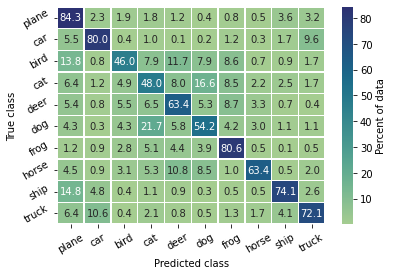

In [23]:
make_heatmap(conf_matrix_simple1)

### Train models with data augmentation

#### Random rotation

In [24]:
train_loader, test_loader = load_dataset(
    batch_size=4, 
    transform_method="random_rotation",
)

nn_training(
    train_loader,
    test_loader,
    nn_name="model_random_rotation", 
    nn_type="SimpleNetBaseline2", 
    n_epochs = 1, 
    l2=0,
    learning_rate=0.001, 
    momentum=0.9,
)

Files already downloaded and verified
Files already downloaded and verified
[1] batch[1500] loss: 2.240, train accuracy: 0.153, test accuracy 0.234 
[1] batch[3000] loss: 1.946, train accuracy: 0.286, test accuracy 0.291 
[1] batch[4500] loss: 1.785, train accuracy: 0.355, test accuracy 0.352 
[1] batch[6000] loss: 1.668, train accuracy: 0.392, test accuracy 0.393 
[1] batch[7500] loss: 1.638, train accuracy: 0.406, test accuracy 0.424 
[1] batch[9000] loss: 1.566, train accuracy: 0.429, test accuracy 0.424 
[1] batch[10500] loss: 1.549, train accuracy: 0.437, test accuracy 0.466 
[1] batch[12000] loss: 1.480, train accuracy: 0.465, test accuracy 0.462 
Finished Training


#### Random horizontal flip

In [25]:
train_loader, test_loader = load_dataset(
    batch_size=4, 
    transform_method="random_horizontal_flip",
)

nn_training(
    train_loader,
    test_loader,
    nn_name="model_random_horizontal_flip", 
    nn_type="SimpleNetBaseline2", 
    n_epochs = 1, 
    l2=0,
    learning_rate=0.001, 
    momentum=0.9,
)

Files already downloaded and verified
Files already downloaded and verified
[1] batch[1500] loss: 2.234, train accuracy: 0.162, test accuracy 0.230 
[1] batch[3000] loss: 1.965, train accuracy: 0.263, test accuracy 0.320 
[1] batch[4500] loss: 1.787, train accuracy: 0.331, test accuracy 0.353 
[1] batch[6000] loss: 1.661, train accuracy: 0.385, test accuracy 0.413 
[1] batch[7500] loss: 1.599, train accuracy: 0.415, test accuracy 0.435 
[1] batch[9000] loss: 1.567, train accuracy: 0.425, test accuracy 0.428 
[1] batch[10500] loss: 1.531, train accuracy: 0.438, test accuracy 0.472 
[1] batch[12000] loss: 1.426, train accuracy: 0.480, test accuracy 0.469 
Finished Training


#### Gray scale

In [26]:
train_loader, test_loader = load_dataset(
    batch_size=4, 
    transform_method="gray_scale",
)

nn_training(
    train_loader,
    test_loader,
    nn_name="model_gray_scale", 
    nn_type="SimpleNetBaseline2", 
    n_epochs = 1, 
    l2=0,
    learning_rate=0.001, 
    momentum=0.9,
)

Files already downloaded and verified
Files already downloaded and verified
[1] batch[1500] loss: 2.299, train accuracy: 0.111, test accuracy 0.143 
[1] batch[3000] loss: 2.133, train accuracy: 0.204, test accuracy 0.227 
[1] batch[4500] loss: 2.001, train accuracy: 0.271, test accuracy 0.303 
[1] batch[6000] loss: 1.859, train accuracy: 0.338, test accuracy 0.359 
[1] batch[7500] loss: 1.769, train accuracy: 0.361, test accuracy 0.374 
[1] batch[9000] loss: 1.695, train accuracy: 0.387, test accuracy 0.397 
[1] batch[10500] loss: 1.637, train accuracy: 0.412, test accuracy 0.426 
[1] batch[12000] loss: 1.604, train accuracy: 0.421, test accuracy 0.436 
Finished Training


#### Cutmix

In [27]:
train_loader, test_loader = load_dataset(
    batch_size=4, 
    transform_method="cutmix",
)

nn_training(
    train_loader,
    test_loader,
    nn_name="model_cutmix", 
    nn_type="SimpleNetBaseline2", 
    n_epochs = 1, 
    l2=0,
    learning_rate=0.001, 
    momentum=0.9,
    is_cutmix=True,
)

Files already downloaded and verified
Files already downloaded and verified
[1] batch[1500] loss: 2.304, train accuracy: 0.198, test accuracy 0.191 
[1] batch[3000] loss: 2.275, train accuracy: 0.287, test accuracy 0.276 
[1] batch[4500] loss: 2.203, train accuracy: 0.315, test accuracy 0.367 
[1] batch[6000] loss: 2.149, train accuracy: 0.361, test accuracy 0.366 
[1] batch[7500] loss: 2.115, train accuracy: 0.379, test accuracy 0.393 
[1] batch[9000] loss: 2.091, train accuracy: 0.388, test accuracy 0.410 
[1] batch[10500] loss: 2.076, train accuracy: 0.409, test accuracy 0.407 
[1] batch[12000] loss: 2.062, train accuracy: 0.416, test accuracy 0.433 
Finished Training


### Experiments for hyperparameters and augumentation

Simple net

In [ ]:
# batch_sizes=[4,8,16]
# learning_rates=[0.001, 0.01, 0.05]
# #no dropout, as simple net do not have it
# transformations=["base", "random_rotation", "random_horizontal_flip", "gray_scale", "cutmix"]
# lambda_l2=[0.1, 0.001, 0.0001]
# iteration =1
# epochs=8
# for batch_size in batch_sizes:
#     for learning_rate in learning_rates:
#         for transformation in transformations:
#             for l2 in lambda_l2:
#                 if transformation=="cutmix":
#                     flag_if_cutmix=True
#                 else: 
#                     flag_if_cutmix=False

#                 #load dataset
#                 train_loader, test_loader = load_dataset(
#                     batch_size=batch_size, 
#                     transform_method=transformation,
#                 )
#                 #train and save model
#                 nn_training(
#                     train_loader,
#                     test_loader,
#                     nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}', 
#                     nn_type="SimpleNetBaseline2", 
#                     n_epochs = epochs, 
#                     l2=l2,
#                     learning_rate=learning_rate, 
#                     momentum=0.9,
#                     is_cutmix=flag_if_cutmix,
#                 )

#                 print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{epochs}')

Complex CNN

In [ ]:
# batch_sizes=[4,8,16]
# learning_rates=[0.001, 0.01, 0.1]
# dropouts = [0.2, 0.4, 0.6]
# transformations=["base", "random_rotation", "random_horizontal_flip", "gray_scale", "cutmix"]
# lambda_l2=[0.1, 0.001, 0.0001]
# iteration =1
# epochs=10
# for batch_size in batch_sizes:
#     for learning_rate in learning_rates:
#         for dropout in dropouts:
#             for transformation in transformations:
#                 for l2 in lambda_l2:
#                     if transformation=="cutmix":
#                         flag_if_cutmix=True
#                     else: 
#                         flag_if_cutmix=False

#                     #load dataset
#                     train_loader, test_loader = load_dataset(
#                         batch_size=batch_size, 
#                         transform_method=transformation,
#                     )
#                     #train and save model
#                     nn_training(
#                         train_loader,
#                         test_loader,
#                         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_dropout_{dropout}_epochs_{epochs}', 
#                         nn_type="MoreComplexNet", 
#                         n_epochs = epochs, 
#                         l2=l2,
#                         learning_rate=learning_rate, 
#                         momentum=0.9,
#                         dropout_p=dropout,
#                         is_cutmix=flag_if_cutmix
#                     )

#                     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_dropout_{dropout}_epochs_{epochs}')

ResNet18 not pre-trained

In [ ]:
# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 12

# batch_sizes = [4, 8, 16, 32]
# learning_rates = [0.001, 0.01, 0.05, 0.1]
# dropouts = [0.2, 0.4, 0.6, 0.8]
# transformations = ["base", "random_rotation", "random_horizontal_flip", "gray_scale", "cutmix"]
# lambda_l2s = [0.1, 0.001, 0.0001, 0]

# for batch_size in batch_sizes:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_not_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')

# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 12

# for learning_rate in learning_rates:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_not_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')

# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 12

# for dropout in dropouts:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_not_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')

# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 12

# for transformation in transformations:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_not_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')

# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 12

# for lambda_l2 in lambda_l2s:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_not_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')


ResNet18 pre-trained

In [ ]:
# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 20

# batch_sizes = [4, 8, 16, 32]
# learning_rates = [0.001, 0.01, 0.05, 0.1]
# dropouts = [0.2, 0.4, 0.6, 0.8]
# transformations = ["base", "random_rotation", "random_horizontal_flip", "gray_scale", "cutmix"]
# lambda_l2s = [0.1, 0.001, 0.0001, 0]

# for batch_size in batch_sizes:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')

# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 20

# for learning_rate in learning_rates:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')

# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 20

# for dropout in dropouts:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')

# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 20

# for transformation in transformations:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')

# batch_size = 16
# learning_rate = 0.003
# dropout = 0
# transformation = "base"
# lambda_l2 = 0
# iteration = 1
# epochs = 20

# for lambda_l2 in lambda_l2s:
#     if transformation=="cutmix":
#         flag_if_cutmix=True
#     else: 
#         flag_if_cutmix=False

#     #load dataset
#     train_loader, test_loader = load_dataset(
#         batch_size=batch_size, 
#         transform_method=transformation,
#     )
#     #train and save model
#     nn_training(
#         train_loader,
#         test_loader,
#         nn_name=f'model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}', 
#         nn_type="ResNet_pretrained", 
#         n_epochs = epochs, 
#         l2 = lambda_l2,
#         learning_rate=learning_rate, 
#         momentum=0.9,
#         dropout_p=dropout,
#         is_cutmix=flag_if_cutmix
#     )

#     print(f'trained and saved: model_{iteration}_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{lambda_l2}_epochs_{epochs}_dropout_{dropout}')


#### Ensemble model

In [29]:
def ensemble_training(
    number_of_models, 
    nn_name, 
    nn_type,
    batch_size,
    transformation,
    n_epochs, 
    l2,
    learning_rate, 
    momentum,
    dropout_p,
    is_cutmix,
    ):
    
    for i in range(number_of_models):
        torch.manual_seed(i)
        torch.cuda.manual_seed(i)
        # load dataset with specific batch_size
        train_loader, test_loader = load_dataset(
            batch_size=batch_size, 
            transform_method=transformation,
            number_of_models=number_of_models,
        )
        #train and save model
        nn_training(
            train_loader,
            test_loader,
            nn_name=f'{nn_name}{i}_model_batch_{batch_size}_lr_{learning_rate}_transf_{transformation}_l2_{l2}_epochs_{n_epochs}_dropout_{dropout_p}', 
            nn_type=nn_type, 
            n_epochs=n_epochs, 
            l2=l2,
            learning_rate=learning_rate, 
            momentum=momentum,
            dropout_p=dropout_p,
            is_cutmix=is_cutmix,
            number_of_models=number_of_models
        )

def ensemble_voting(nn_name, nn_type):
    directory = f"trained_nn/{nn_type}/ensemble"
    neural_networks = []
    for filename in os.listdir(directory):
        if nn_name in filename:
            f = os.path.join(directory, filename)
            neural_networks.append(load_model(nn_name=os.path.splitext(filename)[0], nn_type=nn_type, number_of_models=np.inf))
    
    all_labels_test=[]
    all_predicted_test = []
    for j, data_test in enumerate (test_loader, 0):
        outputs = []
        for nn in neural_networks:
            input_test, label_test = data_test
            label_test_np = label_test.detach().numpy()
            output_test = nn(input_test)
            _, predicted = torch.max(output_test.data, 1)
            outputs.append(np.array(predicted))

        ensemble_predicted = stats.mode(np.array(outputs))[0][0]
        all_predicted_test += list(ensemble_predicted)
        
        for k in range (len(label_test)):
            all_labels_test.append(label_test[k].item())

    acc_test = accuracy_score(all_labels_test, all_predicted_test)

    return acc_test, all_predicted_test

In [30]:
ensemble_training(
    number_of_models=3,
    nn_name="model_ensemble", 
    nn_type="SimpleNetBaseline2", 
    batch_size=4,
    transformation="base",
    n_epochs = 1, 
    l2=0,
    learning_rate=0.001, 
    momentum=0.9,
    dropout_p=0,
    is_cutmix=False,
)

Files already downloaded and verified
Files already downloaded and verified
[1] batch[1500] loss: 2.296, train accuracy: 0.121, test accuracy 0.152 
[1] batch[3000] loss: 2.023, train accuracy: 0.249, test accuracy 0.323 
[1] batch[4500] loss: 1.781, train accuracy: 0.335, test accuracy 0.371 
[1] batch[6000] loss: 1.651, train accuracy: 0.393, test accuracy 0.420 
[1] batch[7500] loss: 1.593, train accuracy: 0.424, test accuracy 0.436 
[1] batch[9000] loss: 1.536, train accuracy: 0.444, test accuracy 0.444 
[1] batch[10500] loss: 1.499, train accuracy: 0.451, test accuracy 0.491 
[1] batch[12000] loss: 1.451, train accuracy: 0.474, test accuracy 0.477 
Finished Training
Files already downloaded and verified
Files already downloaded and verified
[1] batch[1500] loss: 2.239, train accuracy: 0.150, test accuracy 0.210 
[1] batch[3000] loss: 1.963, train accuracy: 0.241, test accuracy 0.299 
[1] batch[4500] loss: 1.802, train accuracy: 0.319, test accuracy 0.373 
[1] batch[6000] loss: 1.7

In [31]:
train_loader, test_loader = load_dataset(
    batch_size=4, 
    transform_method="base",
)

acc, output = ensemble_voting("model_ensemble", "SimpleNetBaseline2")
print(f"Accuracy: {acc}")

Files already downloaded and verified
Files already downloaded and verified
Accuracy: 0.5219


#### Experiments results

In [ ]:
def compare_results(nn_name, nn_type):
    directory = f"trained_nn/{nn_type}"
    neural_networks = []
    names = []
    for filename in os.listdir(directory):
        if nn_name in filename:
            f = os.path.join(directory, filename)
            neural_networks.append(load_model(nn_name=os.path.splitext(filename)[0], nn_type=nn_type))
            names.append(filename)
    
    accuracy_list = []
    for nn in neural_networks:
        all_labels_test=[]
        all_predictions_test=[]
        for j, data_test in enumerate (test_loader, 0):
            input_test, label_test = data_test
            label_test_np = label_test.detach().numpy()
            output_test = nn(input_test)
            _, predicted = torch.max(output_test.data, 1)
            for k in range (len(label_test)):
                all_labels_test.append(label_test[k].item())
                all_predictions_test.append(predicted[k].item())
        acc_test = accuracy_score(all_labels_test, all_predictions_test)
        
        accuracy_list.append(np.round(acc_test, 3))
    
    return names, accuracy_list

##### Resnet not pre-trained

In [ ]:
names, accuracies = compare_results("augmentation_experiment", "ResNet_not_pretrained")

f = sns.scatterplot(x=["base", "cutmix", "gray_scale", "random_horizontal_flip", "random_rotation"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("data augmentation technique", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent data augmentation techniques", fontsize=15)
plt.show()

In [ ]:
names, accuracies = compare_results("learning_rate_experiment", "ResNet_not_pretrained")

f = sns.scatterplot(x=["0.001", "0.003", "0.01", "0.05", "0.1"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("learning rate", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent learning rates", fontsize=15)
plt.show()

In [ ]:
names, accuracies = compare_results("batch_size_experiment", "ResNet_not_pretrained")

f = sns.scatterplot(x=["16", "32", "4", "8"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("batch size", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent batch sizes", fontsize=15)
plt.show()

In [ ]:
names, accuracies = compare_results("dropout_experiment", "ResNet_not_pretrained")

f = sns.scatterplot(x=["0.2", "0.4", "0.6", "0.8", "0"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("dropout", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent dropouts", fontsize=15)
plt.show()

In [ ]:
names, accuracies = compare_results("l2_experiment", "ResNet_not_pretrained")

f = sns.scatterplot(x=["0.0001", "0.001", "0.01", "0"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("lambda l2", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent lambda l2", fontsize=15)
plt.show()

##### Resnet pre-trained

In [ ]:
names, accuracies = compare_results("augmentation_experiment", "ResNet_pretrained")

f = sns.scatterplot(x=["base", "cutmix", "gray_scale", "random_horizontal_flip", "random_rotation"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("data augmentation technique", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent data augmentation techniques", fontsize=15)
plt.show()

In [ ]:
names, accuracies = compare_results("learning_rate_experiment", "ResNet_pretrained")

f = sns.scatterplot(x=["0.001", "0.003", "0.01", "0.05", "0.1"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("learning rate", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent learning rates", fontsize=15)
plt.show()

In [ ]:
names, accuracies = compare_results("batch_size_experiment", "ResNet_pretrained")

f = sns.scatterplot(x=["16", "32", "4", "8"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("batch size", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent batch sizes", fontsize=15)
plt.show()

In [ ]:
names, accuracies = compare_results("dropout_experiment", "ResNet_pretrained")

f = sns.scatterplot(x=["0.2", "0.4", "0.6", "0.8", "0"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("dropout", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent dropouts", fontsize=15)
plt.show()

In [ ]:
names, accuracies = compare_results("l2_experiment", "ResNet_pretrained")

f = sns.scatterplot(x=["0.0001", "0.001", "0.01", "0"], y=accuracies)

plt.xticks(rotation=20)
plt.xlabel("lambda l2", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.title("Comparision of accuracies for not pre-trained ResNet with \ndifferent lambda l2", fontsize=15)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=df32a7ea-133e-49c1-8b06-62e24dc258a2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>